In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np 
import gc

In [2]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Uniques', ascending=False))



In [3]:
#Function used for calculate aggregation statistics (mean, max, min, count) for numeraical variables

def agg_numeric2(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg


In [4]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client


In [5]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
     
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [6]:
# function for diminishing memory used. (optional) 
import sys

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [7]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

# Installments Payments

Installments Payments data include payment history for previous loans at Home Credit. 
There is one row for every made payment and one row for every missed payment.


In [8]:
dfinst = pd.read_csv('C:\\Users\\kbc\\Downloads\\home-credit-default-risk\\installments_payments.csv')
print(dfinst.shape)

(13605401, 8)


## Exploration of Dataframe

In [9]:
summary(dfinst)

Data shape: (13605401, 8)
___________________________
Data Types:
float64    5
int64      3
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
SK_ID_PREV,int64,13605401,997752,0,1000001.0,2843499.000
AMT_PAYMENT,float64,13602496,944236,2905,0.0,3771487.845
AMT_INSTALMENT,float64,13605401,902539,0,0.0,3771487.845
SK_ID_CURR,int64,13605401,339587,0,100001.0,456255.000
DAYS_ENTRY_PAYMENT,float64,13602496,3040,2905,-4921.0,-1.000
DAYS_INSTALMENT,float64,13605401,2922,0,-2922.0,-1.000
NUM_INSTALMENT_NUMBER,int64,13605401,277,0,1.0,277.000
NUM_INSTALMENT_VERSION,float64,13605401,65,0,0.0,178.000


In [10]:
dfinst.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000
SK_ID_CURR,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000
NUM_INSTALMENT_VERSION,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000
NUM_INSTALMENT_NUMBER,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000
DAYS_INSTALMENT,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000
DAYS_ENTRY_PAYMENT,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000
AMT_INSTALMENT,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845
AMT_PAYMENT,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845


In [ ]:
dfinst.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

## Missing Values

In [11]:
# No need to drop any data or column as the missing values percentages are very small.
missing_values_table(dfinst)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


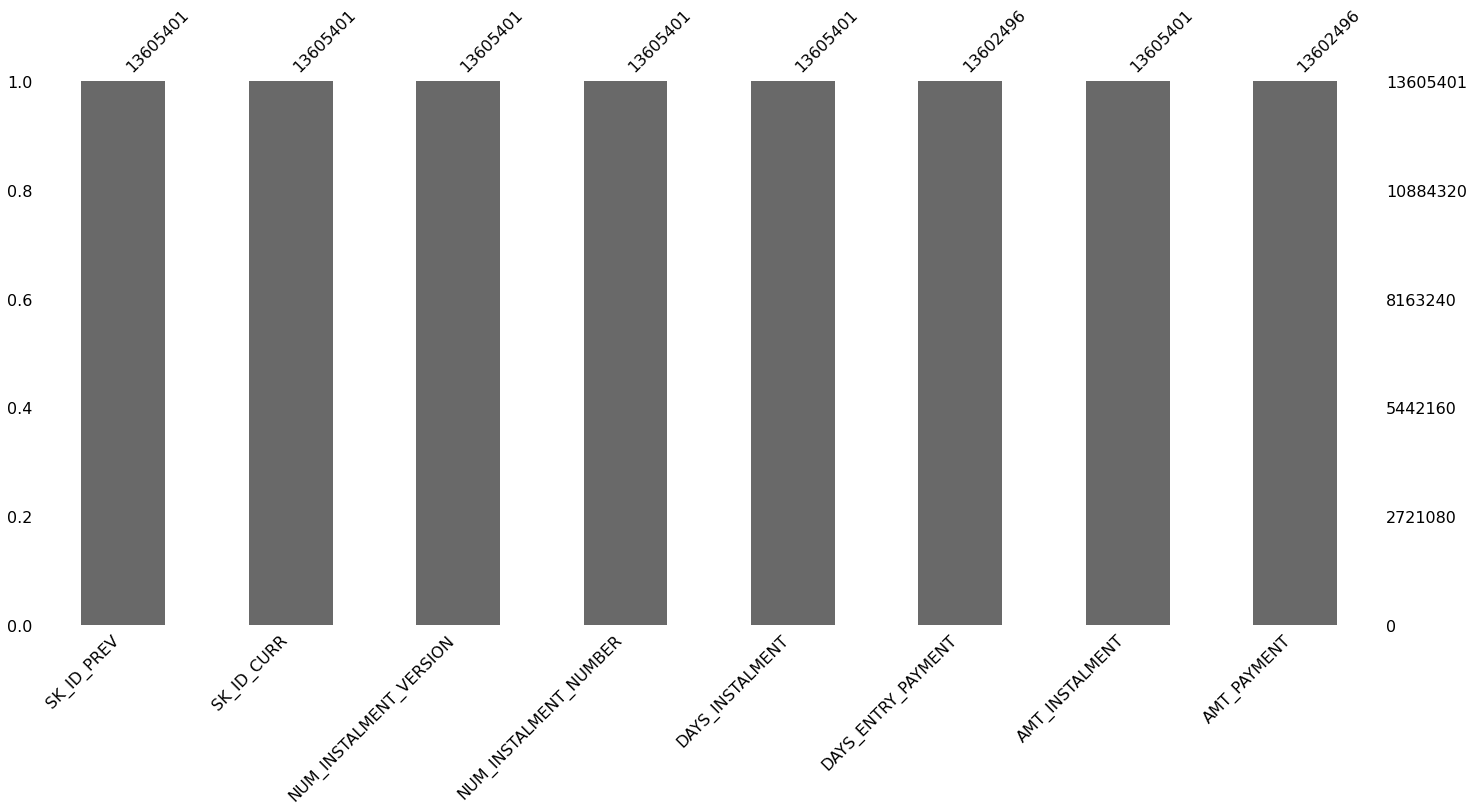

In [15]:
#We can see amount of missing values in bar grafic
import missingno as msno
msno.bar(dfinst);

In [ ]:
summary(installments_by_client)

Data shape: (339587, 106)
___________________________
Data Types:
float64    89
int64      17
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
client_installments_AMT_PAYMENT_sum_sum,float64,339587,337751,0,0.0,3.908885e+09
client_installments_AMT_INSTALMENT_sum_sum,float64,339587,337688,0,0.0,3.923054e+09
client_installments_AMT_INSTALMENT_sum_mean,float64,339587,337359,0,0.0,1.902604e+07
client_installments_AMT_INSTALMENT_mean_sum,float64,339587,337236,0,0.0,3.247978e+07
client_installments_AMT_PAYMENT_mean_sum,float64,339587,337162,0,0.0,3.268928e+07
...,...,...,...,...,...,...
client_installments_NUM_INSTALMENT_VERSION_max_max,float64,339587,54,0,0.0,1.780000e+02
client_installments_NUM_INSTALMENT_NUMBER_min_min,int64,339587,41,0,1.0,6.700000e+01
client_installments_NUM_INSTALMENT_VERSION_max_min,float64,339587,34,0,0.0,4.400000e+01
client_installments_NUM_INSTALMENT_VERSION_min_max,float64,339587,14,0,0.0,7.200000e+01


## Feature Generation

We used a function from Will Koehrsen`s code to aggregate the variables.

In [12]:
dfinstagg = agg_numeric2(dfinst, group_var = 'SK_ID_CURR', df_name = 'instpay')

dfinstagg

,SK_ID_CURR,instpay_NUM_INSTALMENT_VERSION_count,instpay_NUM_INSTALMENT_VERSION_mean,instpay_NUM_INSTALMENT_VERSION_max,instpay_NUM_INSTALMENT_VERSION_min,instpay_NUM_INSTALMENT_VERSION_sum,instpay_NUM_INSTALMENT_NUMBER_count,instpay_NUM_INSTALMENT_NUMBER_mean,instpay_NUM_INSTALMENT_NUMBER_max,instpay_NUM_INSTALMENT_NUMBER_min,...,instpay_AMT_INSTALMENT_count,instpay_AMT_INSTALMENT_mean,instpay_AMT_INSTALMENT_max,instpay_AMT_INSTALMENT_min,instpay_AMT_INSTALMENT_sum,instpay_AMT_PAYMENT_count,instpay_AMT_PAYMENT_mean,instpay_AMT_PAYMENT_max,instpay_AMT_PAYMENT_min,instpay_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132143,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247105,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.586000,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.155000,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205000,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,...,7,7492.924286,12815.010,6605.910,52450.470,7,7492.924286,12815.010,6605.910,52450.470
339583,456252,6,1.000000,1.0,1.0,6.0,6,3.500000,6,1,...,6,10069.867500,10074.465,10046.880,60419.205,6,10069.867500,10074.465,10046.880,60419.205
339584,456253,14,1.000000,1.0,1.0,14.0,14,4.785714,12,1,...,14,4399.707857,5575.185,2754.450,61595.910,14,4115.915357,5575.185,27.270,57622.815
339585,456254,19,1.000000,1.0,1.0,19.0,19,5.263158,10,1,...,19,10239.832895,19065.825,2296.440,194556.825,19,10239.832895,19065.825,2296.440,194556.825


In [13]:
installments_by_client = aggregate_client(dfinst, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,81537.750,81537.750,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1008781.155,1008781.155,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4394101.230,4394101.230,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,158906.205,158906.205,5.054566e+05,5.054566e+05


According to the missing value results, there is nothing to do about missing results in installments paymenst data.

In [14]:
missing_values_table(installments_by_client)

Your selected dataframe has 106 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
client_installments_DAYS_ENTRY_PAYMENT_min_min,9,0.0
client_installments_DAYS_ENTRY_PAYMENT_mean_min,9,0.0
client_installments_AMT_PAYMENT_max_mean,9,0.0
client_installments_AMT_PAYMENT_mean_max,9,0.0
client_installments_AMT_PAYMENT_mean_mean,9,0.0
client_installments_AMT_PAYMENT_max_min,9,0.0
client_installments_AMT_PAYMENT_mean_min,9,0.0
client_installments_AMT_PAYMENT_min_max,9,0.0
client_installments_AMT_PAYMENT_min_mean,9,0.0
client_installments_AMT_PAYMENT_min_min,9,0.0


Ensure there is no object variable.

In [16]:
installments_by_client.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

## Converting data types 

In [17]:
dfinstagg = convert_types(installments_by_client, print_info=True)

Original Memory Usage: 0.29 gb.
New Memory Usage: 0.17 gb.


In [18]:
dfinstagg.dtypes.value_counts()

float32    89
int64      17
dtype: int64

## Saving new file

In [ ]:
dfinstagg.to_csv('/content/drive/MyDrive/home-credit-default-risk/instpay_ready.csv')